# Burnout en empleados corporativos - Aprendizaje de Máquina - TP FINAL

---
## Análisis de Componentes Principales (PCA)
---

#### 1. Carga de datos

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [41]:
# Cargar de los datasets
X_train = pd.read_csv("output/burnout_X_train.csv")
y_train = pd.read_csv("output/burnout_y_train.csv")
X_test = pd.read_csv("output/burnout_X_test.csv")
y_test = pd.read_csv("output/burnout_y_test.csv")

#### 2. PCA - dataset con todas las features

In [42]:
X_train.shape, y_train.shape

((16853, 13), (16853, 1))

In [43]:
from sklearn.decomposition import PCA

# Aplicar PCA
pca = PCA(n_components=6)
components_all = pca.fit_transform(X_train) # Hacer PCA sobre el dataset de train

# Resultado como DataFrame para graficar o analizar
df_components_all = pd.DataFrame(components_all, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'], index=y_train.index)
df_components_all['BurnRate_Class'] = y_train.values

# Aplicar PCA al conjunto de test
components_test = pca.transform(X_test)

print(pca.explained_variance_ratio_)  # % de varianza capturada por cada componente

[0.58795479 0.09851714 0.09271049 0.03662683 0.02818557 0.02497256]


In [44]:
df_components_all.head()

,PC1,PC2,PC3,PC4,PC5,PC6,BurnRate_Class
0,-1.041191,-1.714393,-0.341711,-0.143101,0.142379,-0.276300,1.0
1,2.820136,-0.437159,1.162479,0.687491,-0.205742,-0.634680,0.0
2,-1.046325,-1.075296,-1.185162,0.801379,-0.009905,-0.041372,1.0
3,2.774484,0.321384,1.623802,1.066568,0.759882,0.088296,0.0
4,-2.068310,0.730037,1.750216,0.380441,0.316608,0.864610,2.0


#### 3. Gráfico de varianza explicada acumulada

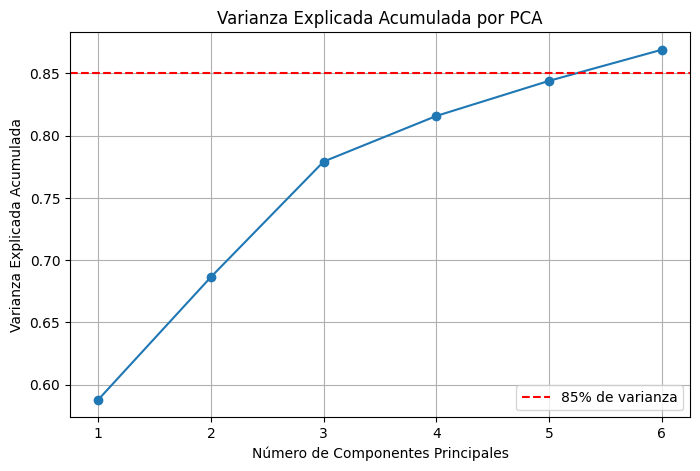

In [45]:
# Varianza explicada por componente
explained_variance = pca.explained_variance_ratio_

# varianza acumulada
cumulative_var = np.cumsum(explained_variance)

plt.figure(figsize=(8,5))
plt.plot(range(1, len(cumulative_var) + 1), cumulative_var, marker='o')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Varianza Explicada Acumulada por PCA')
plt.axhline(y=0.85, color='red', linestyle='--', label='85% de varianza')
plt.xticks([1,2,3,4,5,6])
plt.legend(loc='lower right')
plt.grid()
plt.show()

**Conclusión del gráfico de varianza acumulada**

El análisis de componentes principales (PCA) muestra que con 6 componentes se explica aproximadamente el 87% de la varianza total del dataset.
Dado que este valor supera el umbral establecido del 85%, se decide utilizar estas 6 componentes para generar un conjunto de datos reducido, que será empleado en el entrenamiento y evaluación de los modelos.

#### 4. Exportación del dataset de 6 componentes en .csv

In [46]:
# Convertir X (componentes PCA) a DataFrame
X_train_pca = pd.DataFrame(components_all, columns=[f'PC{i+1}' for i in range(6)])
X_test_pca = pd.DataFrame(components_test, columns=[f'PC{i+1}' for i in range(6)])

# Resetear index por si hay desalineación
X_train_pca.reset_index(drop=True, inplace=True)
X_test_pca.reset_index(drop=True, inplace=True)

# Exportar CSV
X_train_pca.to_csv('output/burnout_X_train_PCA.csv', index=False)
X_test_pca.to_csv('output/burnout_X_test_PCA.csv', index=False)

#### 5. Exportación del pipeline de preprocesamiento (Scaler + PCA)

En entornos de producción o despliegue, es fundamental **guardar el preprocesamiento exacto** aplicado a los datos para poder transformarlos de manera coherente cuando se reciben nuevos datos. En este caso, creamos un `Pipeline` con `StandardScaler` + `PCA`, lo ajustamos sobre el conjunto de entrenamiento, y lo exportamos usando `joblib`.

Esto asegura que cualquier nuevo dataset (por ejemplo, un lote de datos para inferencia) pueda ser transformado **de la misma forma** que los datos de entrenamiento, evitando recalcular PCA o cambiar la estructura de los datos.

A continuación se muestra cómo guardar y reutilizar el pipeline.

In [ ]:
# Cargar los datos de X_train sin escalar (tomado del notebook de EDA)
X_train_full = pd.read_csv("output/burnout_X_train_before_scale.csv")

In [48]:
# Exportar pipeline: StandardScaler + PCA para usar en producción
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import joblib

# Crear pipeline
pipeline_pca = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=6))
])

# Entrenar pipeline con los datos originales sin escalar ni PCA aplicados
pipeline_pca.fit(X_train_full)

# Exportar el pipeline entrenado
joblib.dump(pipeline_pca, 'pipeline_scaler_pca.joblib')
print("Pipeline exportado correctamente: 'pipeline_scaler_pca.joblib'")

Pipeline exportado correctamente: 'pipeline_scaler_pca.joblib'


In [ ]:
# Mostrar como diagrama el pipeline (solo visible en Jupyter Notebook, no en GitHub)
from sklearn import set_config
set_config(display='diagram')  

pipeline_pca

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=6))])

In [54]:
# Cargar los nuevos datos
X_test_before_scale = pd.read_csv("output/burnout_X_test_before_scale.csv")

In [50]:
# Reutilizar pipeline exportado para transformar nuevos datos
pipeline_loaded = joblib.load('pipeline_scaler_pca.joblib')
X_new_transformed = pipeline_loaded.transform(X_test_before_scale)

print("Transformación aplicada exitosamente al nuevo conjunto de datos.")

Transformación aplicada exitosamente al nuevo conjunto de datos.


In [52]:
# Mostrar las primeras filas del nuevo conjunto transformado
columns = [f'PC{i+1}' for i in range(X_new_transformed.shape[1])]
pd.DataFrame(X_new_transformed, columns=columns).head()

,PC1,PC2,PC3,PC4,PC5,PC6
0,-1.532708,-0.170492,1.843527,-0.519919,1.355351,-0.935374
1,-1.656284,1.013842,-0.664125,-0.320986,0.463460,-1.363551
2,3.723925,0.968233,0.396887,-1.025543,-1.910435,-0.213675
3,-1.063504,1.223601,-0.108481,-0.476646,-1.638487,0.421471
4,-3.268608,-1.086651,-0.796532,-0.735063,1.474623,-0.243379


---

#### Nota final sobre implementación

En una arquitectura de producción real, el flujo ideal implicaría:
- Aplicar el pipeline completo de preprocesamiento (escalado + PCA) al dataset original en tiempo de inferencia.
- Transformar nuevos datos directamente usando el objeto `Pipeline` exportado.

Sin embargo, **por simplicidad y para reducir la complejidad en los notebooks**, en este trabajo se decidió:
- Aplicar previamente la transformación de PCA sobre el conjunto de entrenamiento y test.
- Exportar estos resultados intermedios como archivos `.csv` para ser reutilizados por los diferentes modelos.

Este enfoque busca mantener claridad pedagógica y evitar redundancia en el código, sin perder de vista las mejores prácticas para entornos de producción.